In [2]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import miepython
from concurrent import futures
import os
import warnings
warnings.simplefilter('ignore')

### Check the Intensity of scattering from 0-360

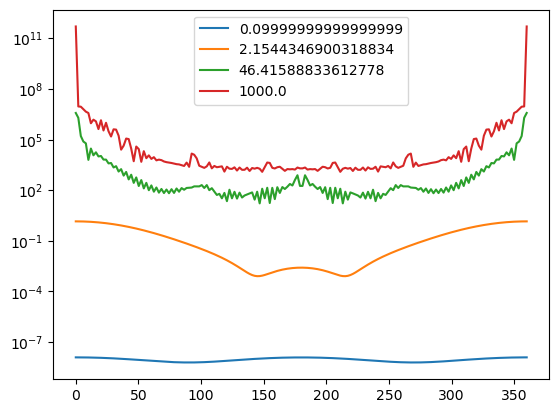

In [5]:
#miepython
fig,ax = plt.subplots()

m = 1.12-0.0006j

angle = np.linspace(0.,360.,180)
mu = np.array([np.cos(np.radians(theta)) for theta in angle])
for x in np.logspace(-1,3,4):
    #mu = 0.001
    S1,S2 = miepython.mie_S1_S2(m,x,mu,norm="wiscombe")
    i1 = np.abs(S1) ** 2
    i2 = np.abs(S2) ** 2
    I  = i1+i2
    ax.plot(angle,I,label=x)
ax.legend()
ax.set_yscale("log")
plt.show()

### plot Qbb(x) :x=1e-1:1e4

In [6]:
### derive Qbb at each m and x
def qbb(m,x):
    def scattering_for_eachAngle(theta):
        cos = np.cos(np.radians(theta))
        sin = np.sin(np.radians(theta))
        S1,S2 = miepython.mie_S1_S2(m,x,cos,norm="wiscombe")
        i1 = abs(S1) ** 2
        i2 = abs(S2) ** 2
        I  = i1+i2
        return I*sin
    integrated,err = integrate.quad(scattering_for_eachAngle,90,180)

    return integrated/(x**2)

In [ ]:
#qbb(1.12-0.0006j,3)
m = 1.12-0.0006j
x=np.logspace(-1,4,10000)
qbb_cal = [qbb(m,x) for x in x]
fig,ax = plt.subplots()
ax.plot(x,qbb_cal)
ax.set_ylabel("Qbb(Backscattering Efficiency Factor)")
ax.set_xlabel("Size Parameter(x)")
ax.set_title("Backscattering Efficiency m=1.12-0.0006j")
ax.set_xscale("log")
plt.show()

### approximate Qbb(x) by polynomial approximation

#### use np.polyfit

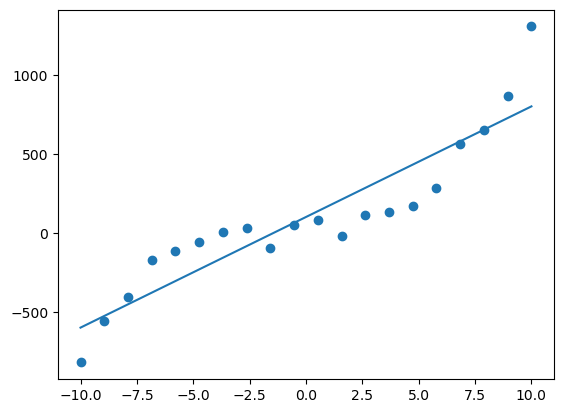

In [4]:
#### example of np.polyfit
x= np.linspace(-10,10,20)
y= x**3 +  2*x**2 + 3*x + 10+ np.random.randn(20)*50
#近似式の係数
res1=np.polyfit(x, y, 1) #1:order
#近似式の計算
y1 = np.poly1d(res1)(x) #1次
#グラフ表示
plt.scatter(x, y)
plt.plot(x, y1)
plt.show()

In [16]:
x=np.logspace(-2,4,1000)
qbb_cal = np.array([qbb(m,x) for x in x])


/tmp/ipykernel_2993841/3448011202.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated,err = integrate.quad(scattering_for_eachAngle,90,180)
/tmp/ipykernel_2993841/3448011202.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrated,err = integrate.quad(scattering_for_eachAngle,90,180)


/tmp/ipykernel_2993841/2796271302.py:4: RankWarning: Polyfit may be poorly conditioned
  reg = np.polyfit(logx,qbb_cal,order)


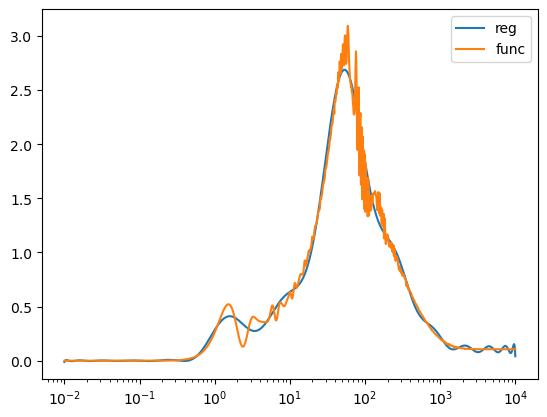

In [47]:
order =40
x=np.logspace(-2,4,1000)
logx = np.log10(x)
reg = np.polyfit(logx,qbb_cal,order)
fx = np.polyval(reg,logx)

#plot
fig,ax = plt.subplots()
ax.plot(10**logx,fx,label="reg")
ax.plot(x,qbb_cal,label="func")
ax.legend()
ax.set_xscale("log")
plt.show()


### Qbb approxiamtion~mpi mode~

#### func

In [17]:
def qbb(D,lambda0=np.linspace(400,800,4),mreal=1.12):

    def n(lambda0,coef1=0.010658,coef2=-0.007186):
        """
        args: 
            lambda (float)(nm) 
            coef1,coef2: parameter for exp
        returns:
            n 複素屈折率の虚部

        """
        return coef1*np.exp(coef2*lambda0)
    
    result = []

    for lambda0 in lambda0:
        x = 2 * np.pi * D /(lambda0*1e-9)
        m = mreal-n(lambda0)*1j

        def scattering_for_eachAngle(theta):
            cos = np.cos(np.radians(theta))
            sin = np.sin(np.radians(theta))

            S1,S2 = miepython.mie_S1_S2(m,x,cos,norm="wiscombe")
            i1 = abs(S1) ** 2
            i2 = abs(S2) ** 2
            I  = i1+i2
            return I*sin

        integrated,err = integrate.quad(scattering_for_eachAngle,90,180,limit=100)
        result.append(integrated/(x**2))
    return result

def regression(x,result,order=40):    
    logx = np.log10(x)
    reg = np.polyfit(logx,result,order)
    fx = np.polyval(reg,logx)
    return reg,fx

def polyfit(PSD,result,wavelength,order=50):
    wave_iter = len(wavelength)
    reg_list = []
    for i in range(wave_iter):
        res = result[:,0]
        reg,fx = regression(PSD,res,order=order)
        reg_list.append(reg)

        #plot
        fig,ax = plt.subplots()
        ax.plot()
        ax.plot(PSD,fx,label="reg")
        ax.plot(PSD,res,label="original")
        ax.legend()
        ax.set_xscale("log")
        plt.show()
        plt.close()
    return reg_list

def task(lambda0,PSD,mreal):
    """
    args:

    lambda0: np.linspace() プロットしたいだけの波長をnp.linspaceの形で
    PSD: 粒径分布をnp.linspace()で。分割数は1000くらい 単位はm
    mreal: 水に対する相対屈折率の実部

    returns:

    future_list : list()
    """

    length = PSD.shape[0]

    #map関数用にPSDと同じ長さの配列にコピー
    mreal = [mreal for i in range(length)]
    lambda_ = [lambda0 for i in range(length)]

    #multi processの開始
    with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
        #map関数でiterable全てに対してqbbを実行
        future_list = executor.map(qbb,PSD,lambda_,mreal)
    result = np.array(list(future_list))
    reg_list = polyfit(PSD,result,lambda0,order=50)
    return reg_list



#### execute

In [6]:
#####(a) set parameters
PSD = np.r_[np.linspace(0.05*1e-6,0.1*1e-6,200),np.linspace(0.1*1e-6,1*1e-6,300)
      ,np.linspace(1*1e-6,10*1e-6,300),np.linspace(10*1e-6,100*1e-6,150)
      ,np.linspace(100*1e-6,500*1e-6,50)]
mreal = 1.12
wavelength = np.linspace(400,800,21)


In [9]:
#####(b) execute function
result = task(wavelength,PSD,mreal)

In [14]:
print(result)

[[0.12638853 0.10755919 0.09191963 ... 0.0124667  0.01128828 0.01024459]
 [0.12847291 0.10937562 0.09350276 ... 0.01270752 0.01150689 0.01044345]
 [0.13057546 0.11120927 0.09510188 ... 0.01295162 0.0117285  0.01064506]
 ...
 [0.10625995 0.1062349  0.10625975 ... 0.65823733 0.75400202 0.82420086]
 [0.10625942 0.10626349 0.10626053 ... 0.67066838 0.75286459 0.83414516]
 [0.10625943 0.10625832 0.10626058 ... 0.6583255  0.72976612 0.83000228]]


#### polyfit

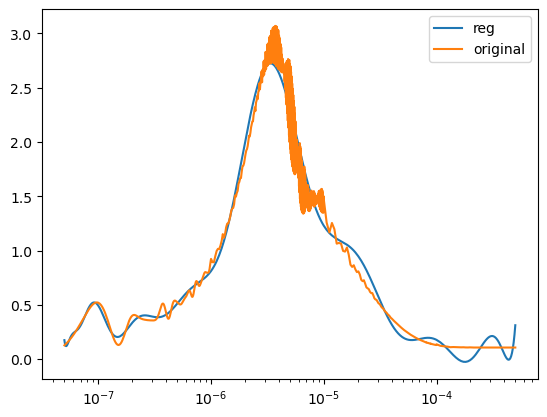

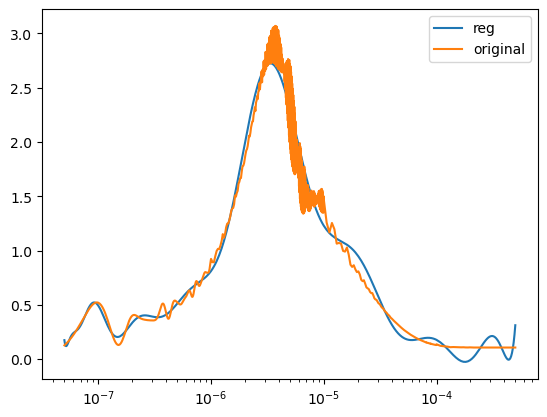

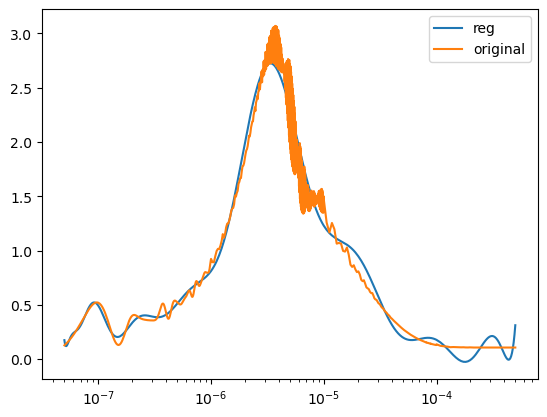

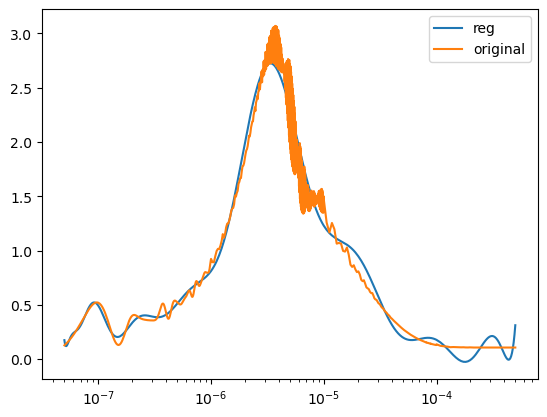

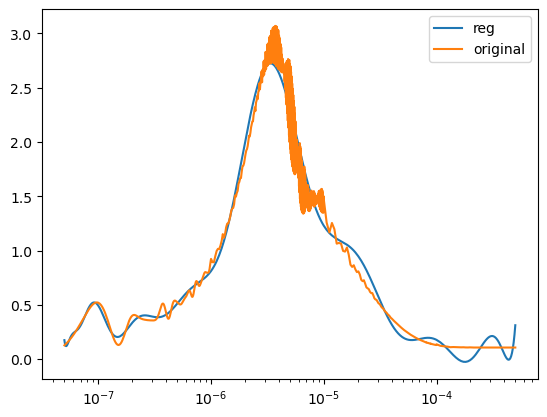

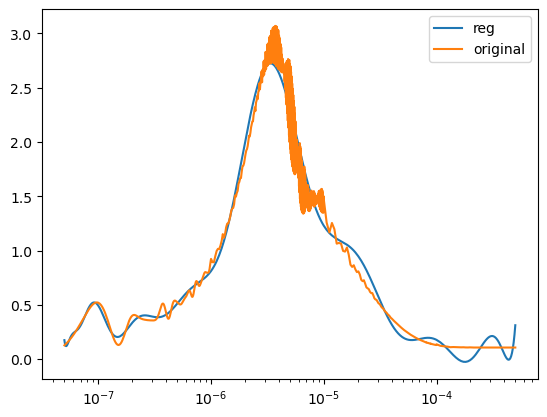

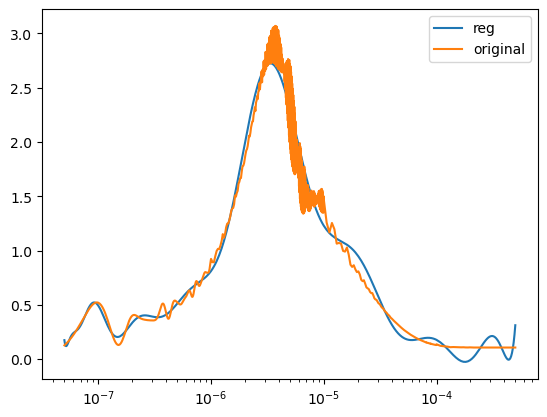

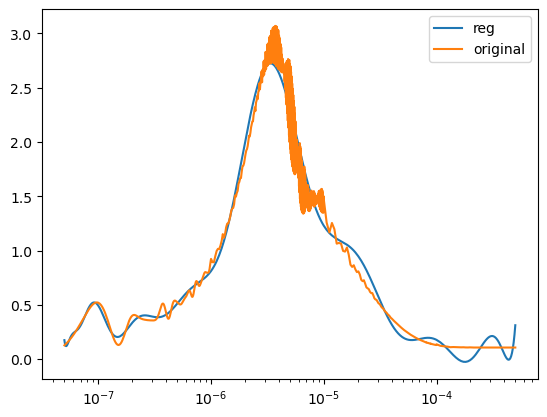

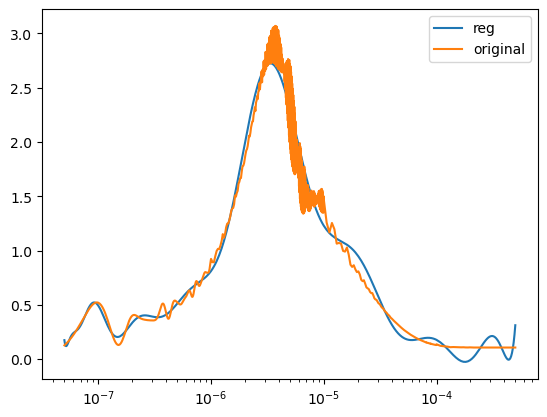

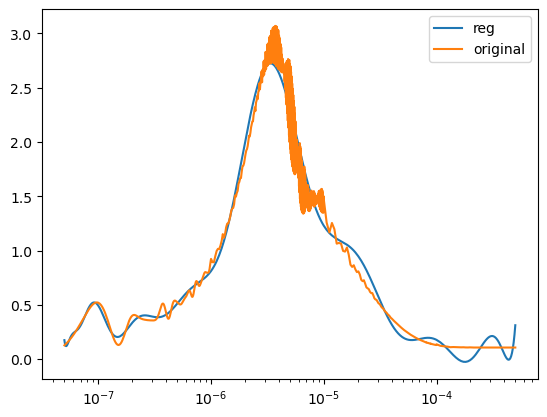

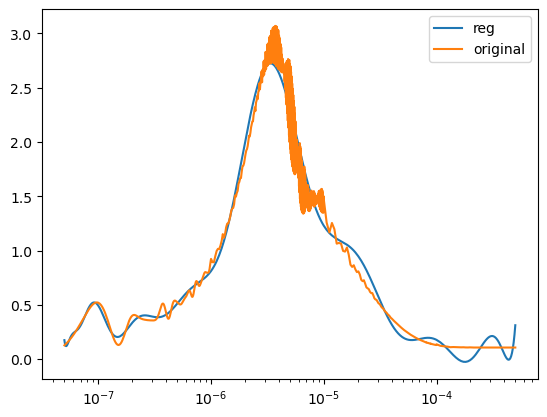

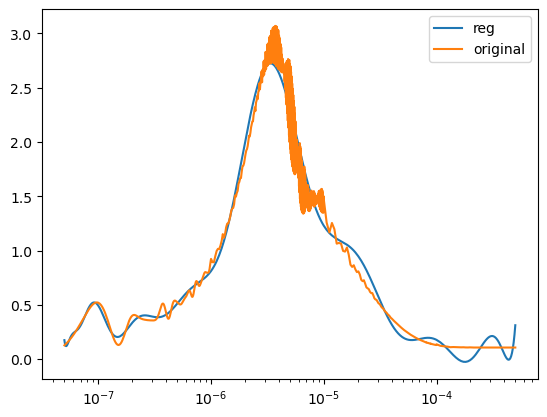

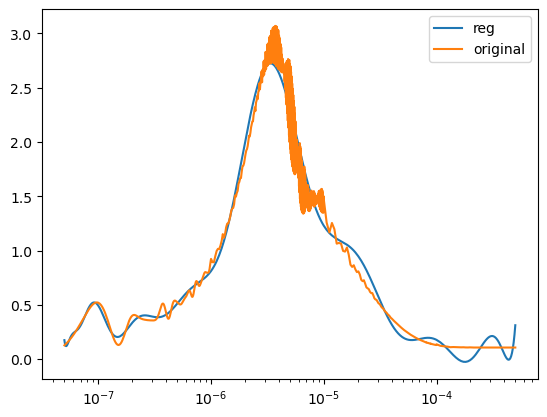

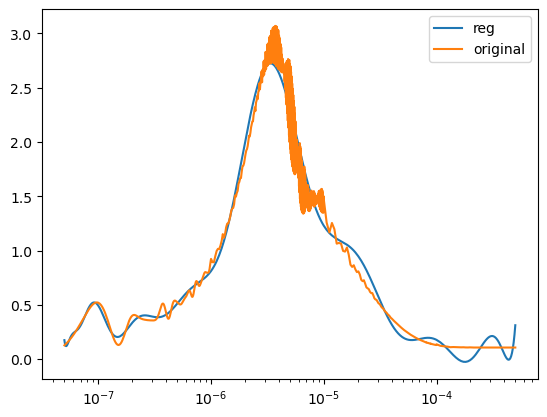

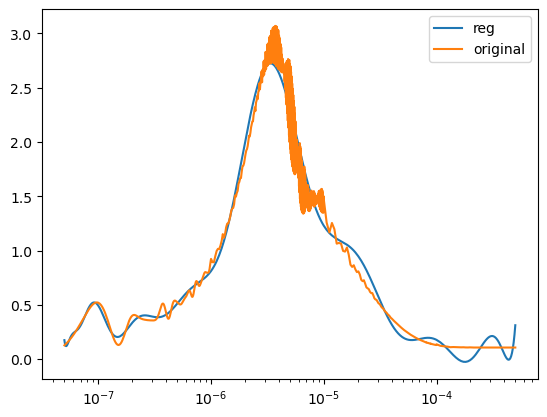

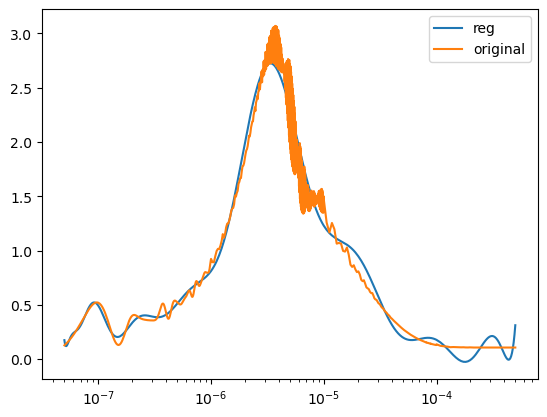

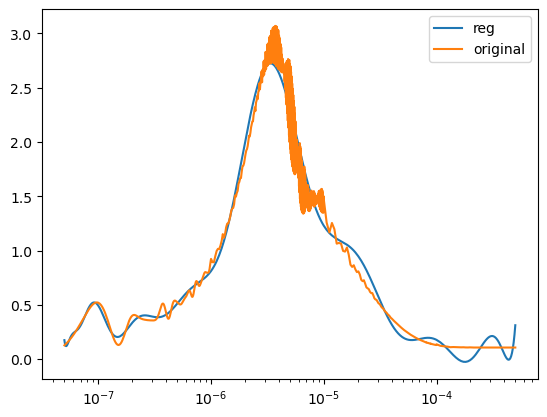

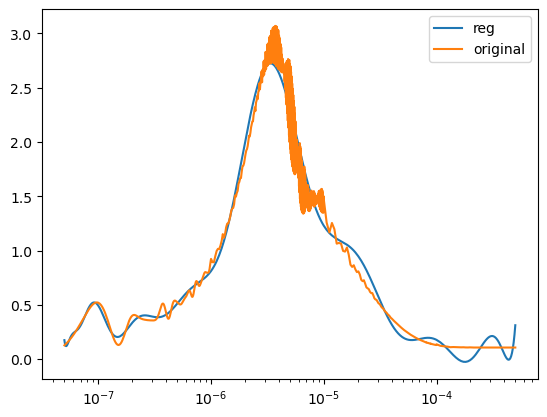

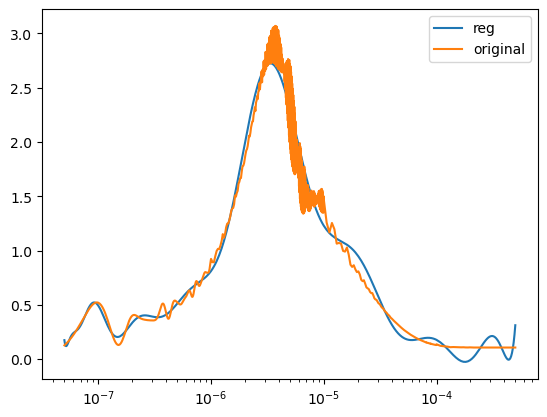

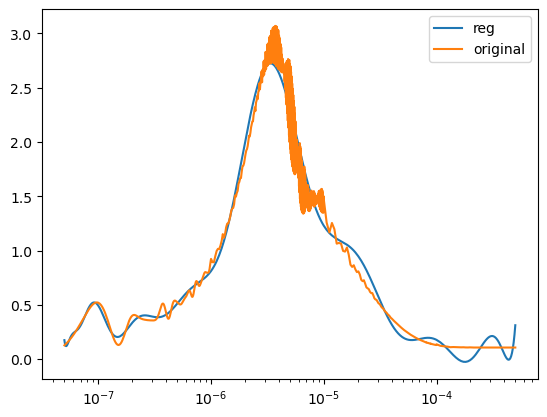

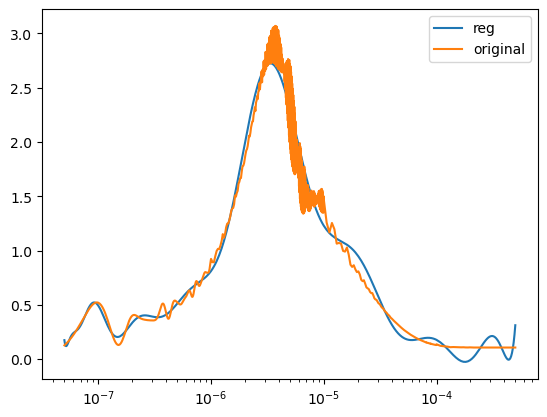

[array([ 6.29692055e-34,  1.06108752e-32, -5.84015987e-34, -3.83968396e-31,
         2.34011346e-30, -8.53606759e-31, -9.91777033e-29,  9.53121254e-28,
        -4.52207256e-27, -5.92697299e-28,  2.28455017e-25, -2.39807193e-24,
         1.44839314e-23, -3.76890879e-23, -3.17764137e-22,  5.46474470e-21,
        -4.50091443e-20,  2.25531290e-19, -2.21266454e-19, -9.18150280e-18,
         1.15175781e-16, -8.20178748e-16,  3.20478093e-15,  7.04663865e-15,
        -2.46614768e-13,  2.35744006e-12, -1.28815885e-11,  1.56124383e-11,
         5.13145908e-10, -6.26670377e-09,  3.82131544e-08, -5.89060254e-08,
        -1.44162888e-06,  1.72589322e-05, -8.72577844e-05, -1.20660329e-04,
         5.73675602e-03, -4.16410014e-02,  2.01770861e-02,  2.09301078e+00,
        -1.48768079e+01, -2.74733906e+01,  9.32971021e+02, -1.73278532e+03,
        -4.72593995e+04,  8.33655710e+04,  2.80810818e+06,  1.48599290e+07,
         3.77805671e+07,  4.90082353e+07,  2.61685909e+07]),
 array([ 6.29692055e-34,  1

In [16]:
def polyfit(PSD,result,wavelength,order=50):
    wave_iter = len(wavelength)
    reg_list = []
    for i in range(wave_iter):
        res = result[:,0]
        reg,fx = regression(PSD,res,order=order)
        reg_list.append(reg)

        #plot
        fig,ax = plt.subplots()
        ax.plot()
        ax.plot(PSD,fx,label="reg")
        ax.plot(PSD,res,label="original")
        ax.legend()
        ax.set_xscale("log")
        plt.show()
        plt.close()
    return reg_list
polyfit(PSD,result,wavelength,order=50)

### make function

In [48]:
def approximate_qbb_polynomial(m,order=40):
    def qbb(m,x):
        def scattering_for_eachAngle(theta):
            cos = np.cos(np.radians(theta))
            sin = np.sin(np.radians(theta))
            S1,S2 = miepython.mie_S1_S2(m,x,cos,norm="wiscombe")
            i1 = abs(S1) ** 2
            i2 = abs(S2) ** 2
            I  = i1+i2
            return I*sin
        integrated,err = integrate.quad(scattering_for_eachAngle,90,180)

        return integrated/(x**2)
    
    x=np.logspace(-2,4,1000)
    qbb_cal = np.array([qbb(m,x) for x in x])

    logx = np.log10(x)
    reg = np.polyfit(logx,qbb_cal,order)

    return reg

In [68]:
def approximate_qbb_polynomial(lambda0,mreal,order=40):
    """
    lambda0 ; wavelength in nm
    D : particle size in m
    """
    def n(lambda0,coef1=0.010658,coef2=-0.007186):
        return 0.010658*np.exp(-0.007186*lambda0)
    def qbb(lambda0,D):
        x = 2 * np.pi * D /(lambda0*1e-9)
        m = mreal-n(lambda0)*1j

        def scattering_for_eachAngle(theta):
            cos = np.cos(np.radians(theta))
            sin = np.sin(np.radians(theta))

            S1,S2 = miepython.mie_S1_S2(m,x,cos,norm="wiscombe")
            i1 = abs(S1) ** 2
            i2 = abs(S2) ** 2
            I  = i1+i2
            return I*sin
        nang = 100
        ang = np.linspace(90,180,nang)
        integrated = 0
        for i,theta in enumerate(ang):
            integrated += scattering_for_eachAngle(theta)
            if i %10 == 0:
                print(i)
        integrated /= nang
        #integrated = np.sum([scattering_for_eachAngle(theta) for theta in ang])/nang
        #integrated,err = integrate.quad(scattering_for_eachAngle,90,180)

        return integrated/(x**2)
    
    D=np.logspace(0.05*1e-6,500*1e-6,10)
    qbb_cal = np.array([qbb(lambda0,D) for D in D])

    #logD = np.log10(D)
    #reg = np.polyfit(logD,qbb_cal,order)

    return #reg,qbb_cal

In [ ]:
approximate_qbb_polynomial(400,1.12,order=40)

0
0
0
0
0
0
0
0
0
0


/tmp/ipykernel_2993841/1504926921.py:38: RankWarning: Polyfit may be poorly conditioned
  reg = np.polyfit(logD,qbb_cal,order)


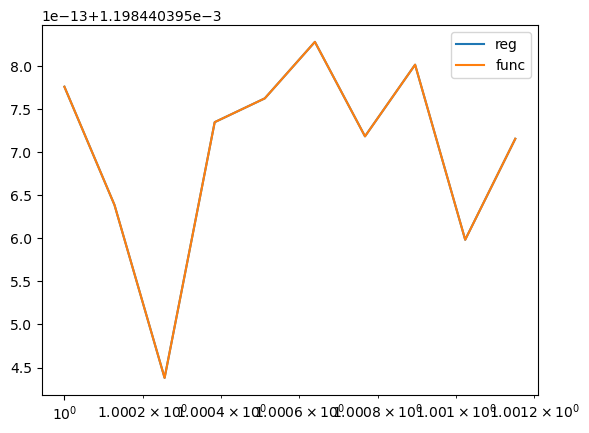

In [65]:
lambda0 = 400
mreal = 1.12
x=np.logspace(0.05*1e-6,500*1e-6,10)
logx = np.log10(x)
reg,qbb_cal = approximate_qbb_polynomial(lambda0,mreal,order=40)
fx = np.polyval(reg,logx)
fig,ax = plt.subplots()
ax.plot(10**logx,fx,label="reg")
ax.plot(x,qbb_cal,label="func")
ax.legend()
ax.set_xscale("log")
plt.show()